# Восстановление золота из руды

Необходио создать модель, которая предскажет коэффициент восстановления золота из золотосодержащей руды.



## Подготовка данных

Импортируем все, что нужно, и посмотрим, что у нас есть

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Т.к. у нас есть пустые строки, заполним их методом backfill, который берет за основу данные из следующего заполненного.

In [ ]:
df_train = df_train.fillna(method='backfill')

In [ ]:
df_test = df_test.fillna(method='backfill')

In [ ]:
df_full = df_full.fillna(method='backfill')

В тестовой выборке отсутствет больше 30 столбцов данных, среди которых столбцы таргеты - rougher.output.recovery и final.output.recovery, которые нам понадобятся в дальнейшем. 

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между  расчётами и значением признака. 

In [ ]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
df_train['rougher.output.recovery_fact'] = (C * (F - T) / (F * (C - T))*100)

In [ ]:
recovery_fact = df_train['rougher.output.recovery_fact']
recovery_was = df_train['rougher.output.recovery']


In [ ]:
print(mean_absolute_error(recovery_was,recovery_fact))

9.73512347450521e-15


In [ ]:
recovery_fact.describe()

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery_fact, dtype: float64

In [ ]:
recovery_was.describe()

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

mae = 9*10 в -15 степени, что означает, что формула обогащения расчитана правильно. Как можно видеть в предыдущих ячейках, данные практически не различаются.


## Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

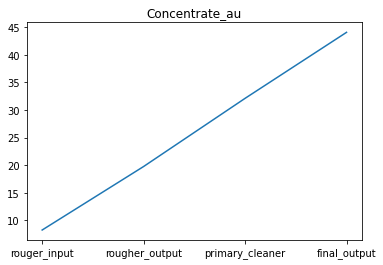

In [ ]:
au_concentrate = [df_full['rougher.input.feed_au'].mean(), 
                  df_full['rougher.output.concentrate_au'].mean(),
                  df_full['primary_cleaner.output.concentrate_au'].mean(), 
                  df_full['final.output.concentrate_au'].mean()]
time = ['rouger_input', 'rougher_output', 'primary_cleaner', 'final_output']
plt.plot(time, au_concentrate)
plt.title('Concentrate_au')
plt.show()

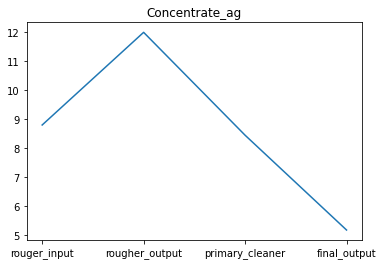

In [ ]:
ag_concentrate = [df_full['rougher.input.feed_ag'].mean(), 
                  df_full['rougher.output.concentrate_ag'].mean(),
                  df_full['primary_cleaner.output.concentrate_ag'].mean(), 
                  df_full['final.output.concentrate_ag'].mean()]
time = ['rouger_input', 'rougher_output', 'primary_cleaner', 'final_output']
plt.plot(time, ag_concentrate)
plt.title('Concentrate_ag')
plt.show()

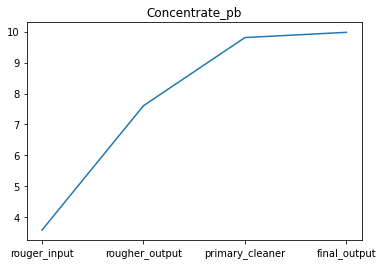

In [ ]:
pb_concentrate = [df_full['rougher.input.feed_pb'].mean(), 
                  df_full['rougher.output.concentrate_pb'].mean(),
                  df_full['primary_cleaner.output.concentrate_pb'].mean(), 
                  df_full['final.output.concentrate_pb'].mean()]
time = ['rouger_input', 'rougher_output', 'primary_cleaner', 'final_output']
plt.plot(time, pb_concentrate)
plt.title('Concentrate_pb')
plt.show()

Концентрация золота и свинца растет, серебра падает.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

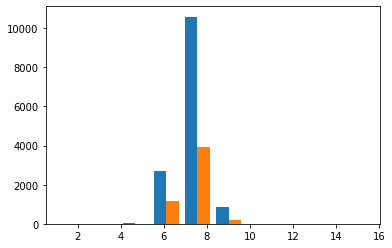

In [ ]:
size_train = df_train['primary_cleaner.input.feed_size']
size_test = df_test['primary_cleaner.input.feed_size']


plt.hist([size_train, size_test], bins=10)
plt.show()

Распределение размеров сырья практически одинаковое.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [ ]:
df_train['feed_conc'] = df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_pb'] + df_train['rougher.input.feed_sol'] + df_train['rougher.input.feed_au']

<AxesSubplot:>

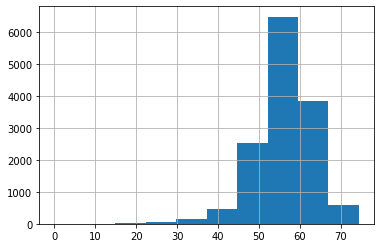

In [ ]:
df_train['feed_conc'].hist()


In [ ]:
display(df_train.loc[df_train['feed_conc'] == 0])

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_fact,feed_conc


In [ ]:
df_train['rougher_conc'] = df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol'] + df_train['rougher.output.concentrate_au']

<AxesSubplot:>

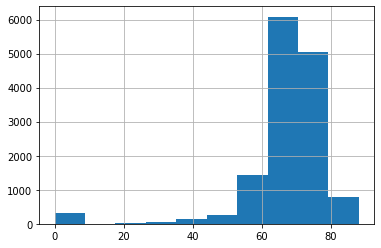

In [ ]:
df_train['rougher_conc'].hist()

In [ ]:
display(df_train.loc[df_train['rougher_conc'] == 0])

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_fact,feed_conc,rougher_conc
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228,-0.0,58.602038,0.0
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683,-0.0,59.921613,0.0
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665,-0.0,27.102702,0.0
48,2016-01-17 00:00:00,5.296830,10.597469,3.997737,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603,-0.0,25.352358,0.0
49,2016-01-17 02:00:00,8.162896,8.877528,3.997737,40.715973,49.884856,10.381465,1.024030,12.974257,2.739224,...,-550.549773,9.941869,-503.282068,8.018850,-500.970716,11.991078,-598.475929,-0.0,40.721375,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10330,2018-02-11 23:59:59,4.909904,9.941006,8.191698,47.660737,83.597741,8.853800,0.717677,13.399798,1.515512,...,-500.386063,10.998883,-499.846204,8.972741,-500.118532,10.966205,-500.707126,-0.0,58.106496,0.0
10331,2018-02-12 00:59:59,4.797572,9.889303,8.326773,47.801056,84.738648,8.503813,0.757507,13.591903,1.573222,...,-499.891798,11.010768,-494.562898,9.028307,-499.007596,10.978016,-497.924873,-0.0,59.500740,0.0
10332,2018-02-12 01:59:59,4.329492,9.413122,8.173988,49.412576,73.519948,8.846540,1.479231,13.094763,2.760905,...,-499.873967,11.034954,-493.250025,9.029441,-480.953533,11.021042,-499.685577,-0.0,60.129638,0.0
10333,2018-02-12 02:59:59,4.317169,9.642271,8.396492,48.839994,78.415342,8.485093,1.155559,13.380461,2.198065,...,-500.084773,10.972473,-511.806312,8.991251,-500.706169,10.990072,-499.775802,-0.0,59.267147,0.0


In [ ]:
df_train.dropna(subset=['rougher_conc'])

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_fact,feed_conc,rougher_conc
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,51.680034,66.424950
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,50.659114,67.012710
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,50.609929,66.103793
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,51.061546,65.752751
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,47.859163,65.908382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,89.574376,53.415050,70.781325
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,87.724007,53.696482,70.539603
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,88.890579,54.589604,55.376330
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,54.027355,69.201689


In [ ]:
df_train['final_conc'] = df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol'] + df_train['final.output.concentrate_au']

<AxesSubplot:>

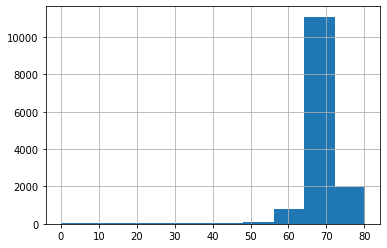

In [ ]:
df_train['final_conc'].hist()

In [ ]:
display(df_train.loc[df_train['final_conc'] == 0])


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_fact,feed_conc,rougher_conc,final_conc
644,2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,...,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808,68.960993,46.703740,56.574778,0.0
1193,2016-03-11 10:00:00,0.0,0.0,0.0,0.0,0.0,10.817313,1.462800,16.407607,2.984504,...,11.982937,-449.856468,9.927727,-450.521700,19.971682,-500.685521,82.787322,53.368945,61.681632,0.0
1194,2016-03-11 11:00:00,0.0,0.0,0.0,0.0,0.0,10.436792,1.207636,17.800392,2.747294,...,11.844983,-450.881424,9.916784,-449.542871,20.004767,-500.137068,83.515262,51.963364,60.214950,0.0
1195,2016-03-11 12:00:00,0.0,0.0,0.0,0.0,0.0,10.637073,1.405778,17.195897,2.791440,...,12.091144,-496.404140,9.976074,-496.783155,19.921634,-500.769011,83.702224,48.892687,58.592426,0.0
1196,2016-03-11 13:00:00,0.0,0.0,0.0,0.0,0.0,10.530320,1.461550,17.556860,2.682127,...,12.078809,-499.903743,10.075259,-499.540325,20.039788,-499.932405,84.836821,49.265736,58.363177,0.0
1682,2016-04-09 17:00:00,0.0,0.0,0.0,0.0,0.0,2.943613,1.089791,4.050067,2.443084,...,12.012947,-498.936345,9.989854,-800.001639,19.960963,-500.498255,-0.000000,44.882879,0.000000,0.0
2019,2016-05-01 23:59:59,0.0,0.0,0.0,0.0,0.0,2.229996,0.439314,2.996147,1.049438,...,8.851882,-503.279765,9.037939,-500.400661,15.999356,-509.449510,65.593784,57.115449,82.097253,0.0
2020,2016-05-02 00:59:59,0.0,0.0,0.0,0.0,0.0,8.816376,1.692314,12.001629,3.949153,...,8.972976,-498.876974,9.070907,-499.455708,16.026009,-492.939580,76.468239,56.001311,80.583896,0.0
2236,2016-05-11 01:59:59,0.0,0.0,0.0,0.0,0.0,7.567252,1.991327,12.977099,3.170143,...,11.025995,-501.002632,6.093285,-500.452445,20.023462,-500.365653,69.679278,56.164944,76.009105,0.0
3394,2016-07-06 04:59:59,0.0,0.0,0.0,0.0,0.0,6.266939,2.146631,7.240419,3.552111,...,16.993432,-501.022669,14.951274,-499.908216,24.984095,-499.000500,65.867550,51.820284,70.389606,0.0


In [ ]:
df_train = df_train.loc[df_train['feed_conc'] != 0] 

In [ ]:
df_train.loc[df_train['rougher_conc'] != 0] 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_fact,feed_conc,rougher_conc,final_conc
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,51.680034,66.424950,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,50.659114,67.012710,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,50.609929,66.103793,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,51.061546,65.752751,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,47.859163,65.908382,64.004667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,89.574376,53.415050,70.781325,68.098589
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,87.724007,53.696482,70.539603,68.274362
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,88.890579,54.589604,55.376330,68.226068
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,54.027355,69.201689,68.200449


In [ ]:
df_train.loc[df_train['final_conc'] != 0]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_fact,feed_conc,rougher_conc,final_conc
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,51.680034,66.424950,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,50.659114,67.012710,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,50.609929,66.103793,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,51.061546,65.752751,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,47.859163,65.908382,64.004667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,89.574376,53.415050,70.781325,68.098589
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,87.724007,53.696482,70.539603,68.274362
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,88.890579,54.589604,55.376330,68.226068
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,54.027355,69.201689,68.200449


In [ ]:
df_test['feed_conc'] = df_test['rougher.input.feed_ag'] + df_test['rougher.input.feed_pb'] + df_test['rougher.input.feed_sol'] + df_test['rougher.input.feed_au']

<AxesSubplot:>

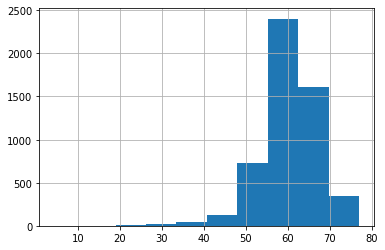

In [ ]:
df_test['feed_conc'].hist()

In [ ]:
df_test.loc[df_test['feed_conc'] != 0]

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,feed_conc
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,72.871822
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,71.669225
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,73.202598
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,70.757057
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,68.654396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909,68.910849
5286,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761,67.166899
5287,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882,66.955814
5288,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,67.420094


Исследовав концентрацию веществ на разных стадиях, провели работу по удалению строк с нулевыми значениями, тк не может быть нулевой концентрации веществ

## Модель

In [ ]:
df_train.drop([col for col in df_train.columns if col not in df_test], axis=1, inplace=True)

In [ ]:
df_train = df_train.merge(df_full[['date','rougher.output.recovery', 'final.output.recovery']], on='date')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 14148
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        14149 non-null  object 
 1   primary_cleaner.input.sulfate               14149 non-null  float64
 2   primary_cleaner.input.depressant            14149 non-null  float64
 3   primary_cleaner.input.feed_size             14149 non-null  float64
 4   primary_cleaner.input.xanthate              14149 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64
 7   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64
 8   primary_cleaner.state.floatbank8_b_level    14149 non-null  float64
 9   primary_cleaner.state.floatbank8_c_air      14149 non-null  float64
 10  primary_cl

Удалили столбцы, которых нет в тестовой выборке, и добавили столбцы с таргетами

Функция для вычисления итоговой sMAPE.

In [ ]:
def sMAPE(target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions-target) / (np.abs(target) + np.abs(predictions)))
smape =  make_scorer(sMAPE, greater_is_better=False)

In [ ]:
features_r = df_full.drop(['date', 'rougher.output.recovery'], axis=1)
target_r = df_full['rougher.output.recovery']

In [ ]:
features_f = df_full.drop(['date', 'final.output.recovery'], axis=1)
target_f = df_full['final.output.recovery']

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

In [ ]:
model = DecisionTreeRegressor(random_state=0)
scores_r = cross_val_score(model, features_r, target_r, scoring=smape, cv=5, verbose=1) 
scores_f = cross_val_score(model, features_f, target_f, scoring=smape, cv=5, verbose=1) 
final_score = pd.Series(0.25*scores_r+0.75*scores_f).mean()
print('Средняя оценка качества модели:', final_score *(-1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Средняя оценка качества модели: 2.8570081868541006


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s finished


In [ ]:
model = LinearRegression()
scores_r = cross_val_score(model, features_r, target_r, scoring=smape, cv=5, verbose=1) 
scores_f = cross_val_score(model, features_f, target_f, scoring=smape, cv=5, verbose=1) 
final_score = pd.Series(0.25*scores_r+0.75*scores_f).mean()
print('Средняя оценка качества модели:', final_score *(-1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Средняя оценка качества модели: 6.118472279862077


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.1s finished


In [ ]:
model = RandomForestRegressor()
scores_r = cross_val_score(model, features_r, target_r, scoring=smape, cv=5, verbose=1) 
scores_f = cross_val_score(model, features_f, target_f, scoring=smape, cv=5, verbose=1) 
final_score = pd.Series(0.25*scores_r+0.75*scores_f).mean()
print('Средняя оценка качества модели:', final_score *(-1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Добавляем столбцы с таргетами в тестовую выборку

In [ ]:
df_test = df_test.merge(df_full[['date','rougher.output.recovery', 'final.output.recovery']], on='date')

In [ ]:
features_test_r = df_test.drop(['date', 'rougher.output.recovery'], axis=1)
target_test_r = df_test['rougher.output.recovery']


In [ ]:
features_test_f = df_test.drop(['date', 'final.output.recovery'], axis=1)
target_test_f = df_test['final.output.recovery']

In [ ]:
features_train_r = df_train.drop(['date', 'rougher.output.recovery'], axis=1)
target_train_r = df_train['rougher.output.recovery']

In [ ]:
features_train_f = df_train.drop(['date', 'final.output.recovery'], axis=1)
target_train_f = df_train['final.output.recovery']

In [ ]:
model = RandomForestRegressor()
model.fit(features_train_r, target_train_r)
predicted_test_r = model.predict(features_test_r)
print(r2_score(target_test_r, predicted_test_r))

<div class="alert alert-info"> отрицательное значение говорит, что модель никуда не годится, попробуем другие
</div>

In [ ]:
model = LinearRegression()
model.fit(features_train_r, target_train_r)
predicted_test_r = model.predict(features_test_r)
print(r2_score(target_test_r, predicted_test_r))

In [ ]:
model = DecisionTreeRegressor()
model.fit(features_train_r, target_train_r)
predicted_test_r = model.predict(features_test_r)
print(r2_score(target_test_r, predicted_test_r))

In [ ]:
model = RandomForestRegressor()
model.fit(features_train_f, target_train_f)
predicted_test_f = model.predict(features_test_f)
print(r2_score(target_test_f, predicted_test_f))

модель RandomForestRegressor показала наилучшие результаты, что подтверждается на тестовой выборке.

ИТОГО:

1) был проведен анализ восстаноления золота из руды

2) проверена формула вычисления эффективности обогащения, проанализированы признаки, недоступные в тестовой выборке, проведена предобработка данных

3) было исследовано, как меняется концентрация металлов на разных стадиях очистки, как меняется распределение размеров гранул, исследованы суммарные концентрации металлов

4) написана функция sMAPE, были обучены 3 модели, из которых RandomForestRegresso на кросс-валидации показала лучшие результаты, которые были проверены на тестовой выборке на тестовой выборке